# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exploratory Data Analysis

In [2]:
# Load the data

data = pd.read_csv('data/amazon_alexa.tsv', delimiter='\t', quoting=3)
print(f'Rows : {data.shape[0]}\nColumns : {data.shape[1]}')
data.head()

Rows : 3150
Columns : 5


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
# Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [4]:
# Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [5]:
# Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [6]:
# Dropping the record where 'verified_reviews' is null

data.dropna(inplace=True)

In [7]:
print(f"Dataset shape after dropping null values :")
print(f'Rows : {data.shape[0]}\nColumns : {data.shape[1]}')

Dataset shape after dropping null values :
Rows : 3149
Columns : 5


In [8]:
# Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [9]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [10]:
# Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") # Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}")  # Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}")  # Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


We can see that the length of review is the same as the value in the length column for that record

In [11]:
# Checking the details of the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3149 non-null   int64 
 1   date              3149 non-null   object
 2   variation         3149 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3149 non-null   int64 
 5   length            3149 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 172.2+ KB


* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [12]:
# Checking the distinct values of 'rating' column and its count

data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

Let's plot the above values in a bar graph

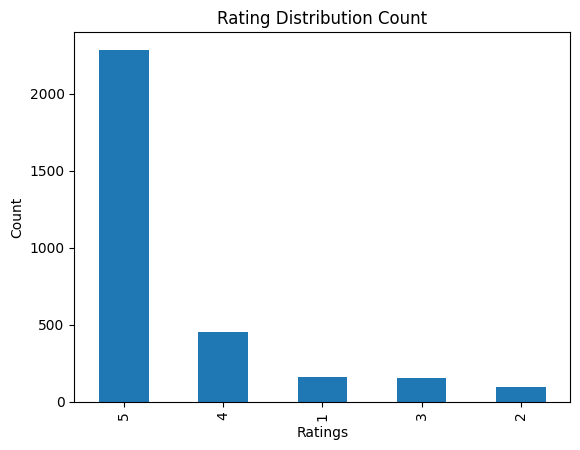

In [13]:
# Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot(kind='bar')
plt.title('Rating Distribution Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
# Distribution of each rating in percentage

(data['rating'].value_counts(normalize=True) * 100).round(2)

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: proportion, dtype: float64

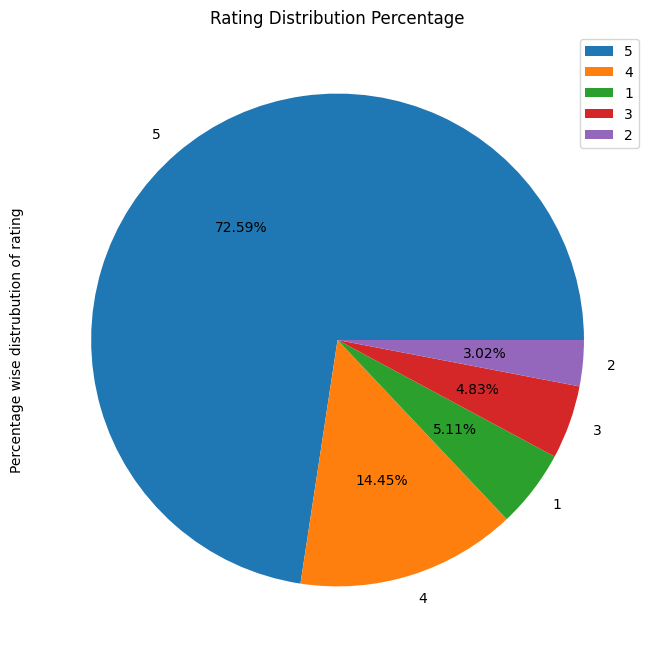

In [48]:
# Plot to visualize the distribution of each rating using pie chart

plt.figure(figsize=(8,8))
data['rating'].value_counts().plot(kind='pie',
                                   autopct='%.2f%%',
                                   label='Percentage wise distrubution of rating')
plt.title('Rating Distribution Percentage')
plt.legend()
plt.show()

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [33]:
# Checking the distinct values of 'feedback' column and its count

data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [34]:
# Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [35]:
# Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

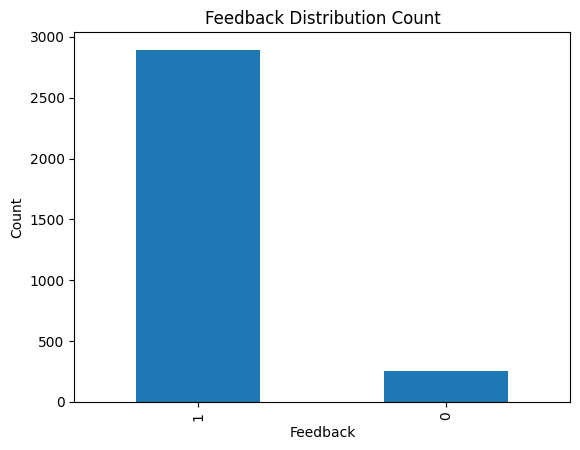

In [36]:
# Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot(kind='bar')
plt.title('Feedback Distribution Count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [37]:
# Distribution of each rating in percentage

(data['feedback'].value_counts(normalize=True) * 100).round(2)

feedback
1    91.87
0     8.13
Name: proportion, dtype: float64

Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

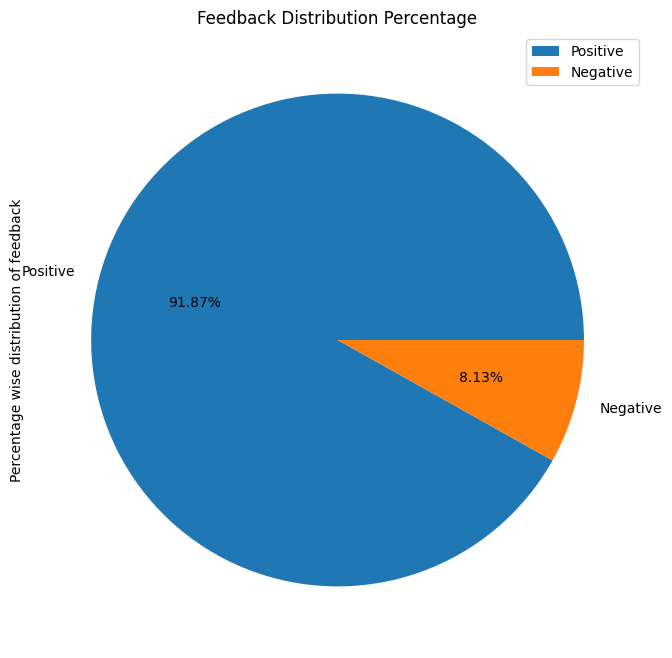

In [47]:
# Plot to visualize the distribution of each feedback using pie chart

# Define custom labels for the feedback values
labels = ['Positive' if i == 1 else 'Negative' for i in data['feedback'].value_counts().index]

plt.figure(figsize=(8,8))
data['feedback'].value_counts().plot(kind='pie',
                                     autopct='%.2f%%',
                                     labels=labels,
                                     label='Percentage wise distribution of feedback')
plt.title('Feedback Distribution Percentage')
plt.legend()
plt.show()

Let's see the 'rating' values for different values of 'feedback'

In [49]:
# Feedback = 0

data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [50]:
# Feedback = 1

data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [51]:
# Checking the distinct values of 'variation' column and its count

data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

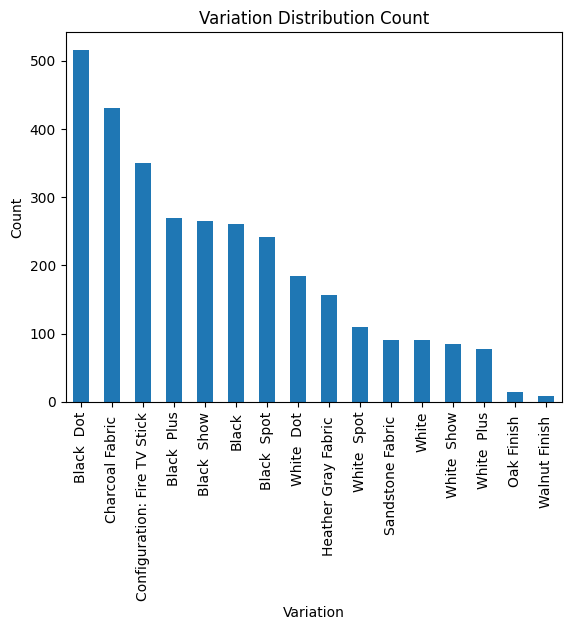

In [52]:
# Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot(kind='bar')
plt.title('Variation Distribution Count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [53]:
# Distribution of each variation in percentage

data['variation'].value_counts(normalize=True) * 100

variation
Black  Dot                      16.386154
Charcoal Fabric                 13.655129
Configuration: Fire TV Stick    11.114640
Black  Plus                      8.574151
Black  Show                      8.415370
Black                            8.288346
Black  Spot                      7.653223
White  Dot                       5.843125
Heather Gray Fabric              4.985710
White  Spot                      3.461416
Sandstone Fabric                 2.858050
White                            2.858050
White  Show                      2.699270
White  Plus                      2.476977
Oak Finish                       0.444586
Walnut Finish                    0.285805
Name: proportion, dtype: float64

Mean rating according to variation

In [54]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Let's analyze the above ratings

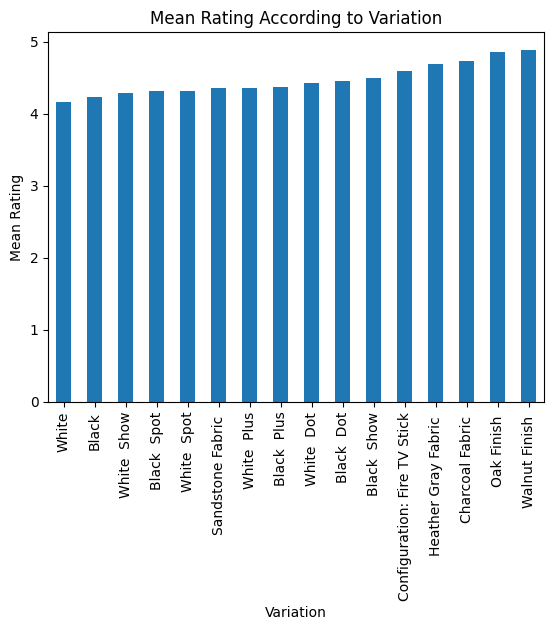

In [56]:
data.groupby('variation')['rating'].mean().sort_values().plot(kind='bar')
plt.title('Mean Rating According to Variation')
plt.xlabel('Variation')
plt.ylabel('Mean Rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [57]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

Length analysis for full dataset

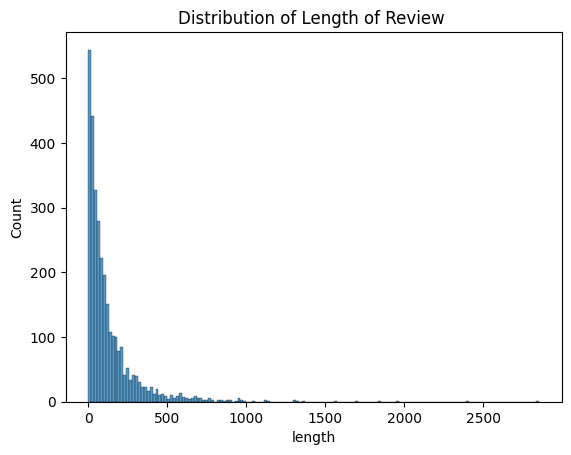

In [63]:
sns.histplot(data['length']).set(title='Distribution of Length of Review ')
plt.show()

Length analysis when feedback is 0 (negative)

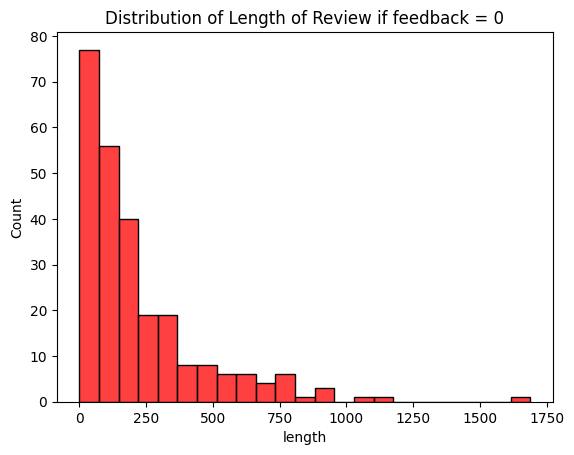

In [64]:
sns.histplot(data[data['feedback']==0]['length'],color='red')
plt.title('Distribution of Length of Review if feedback = 0')
plt.show()

Length analysis when feedback is 1 (positive)

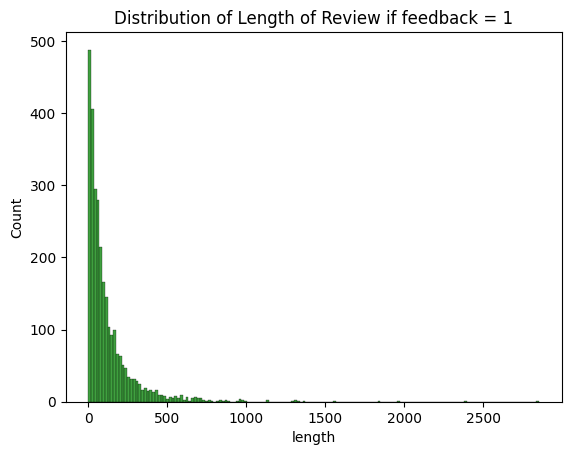

In [65]:
sns.histplot(data[data['feedback']==1]['length'],color='green')
plt.title('Distribution of Length of Review if feedback = 1')
plt.show()

Lengthwise mean rating

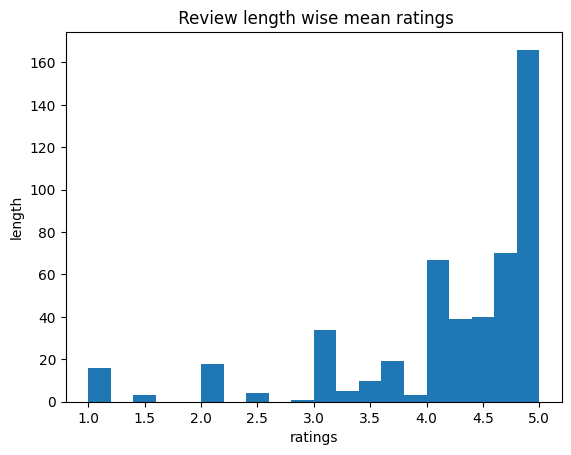

In [68]:
data.groupby('length')['rating'].mean().plot(kind='hist', bins=20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [69]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

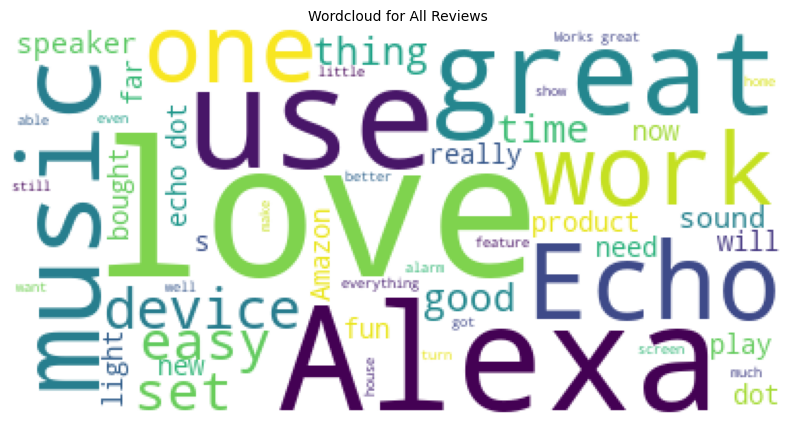

In [70]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for All Reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [71]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# Finding words from reviews which are present in that feedback category only
unique_neg_words = [word for word in neg_reviews if word not in pos_reviews]
unique_neg_words = " ".join(unique_neg_words)

unique_pos_words = [word for word in pos_reviews if word not in neg_reviews]
unique_pos_words = " ".join(unique_pos_words)

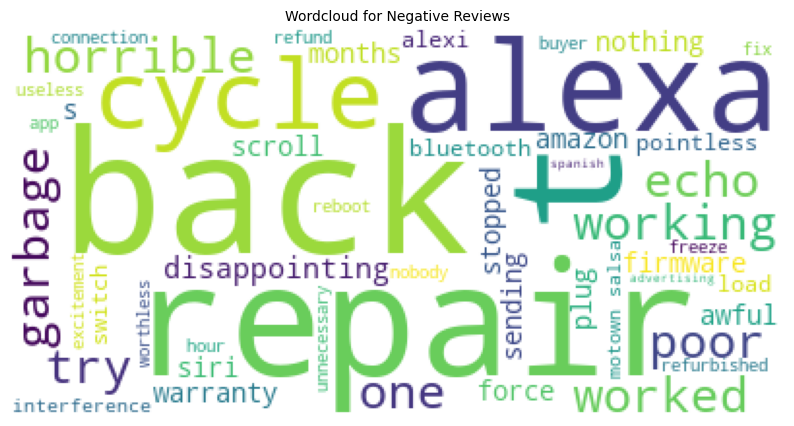

In [ ]:
# Create wordcloud for negative reviews

wc = WordCloud(background_color='white', max_words=50)

# Generate and plot word cloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_neg_words))
plt.title('Wordcloud for Negative Reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

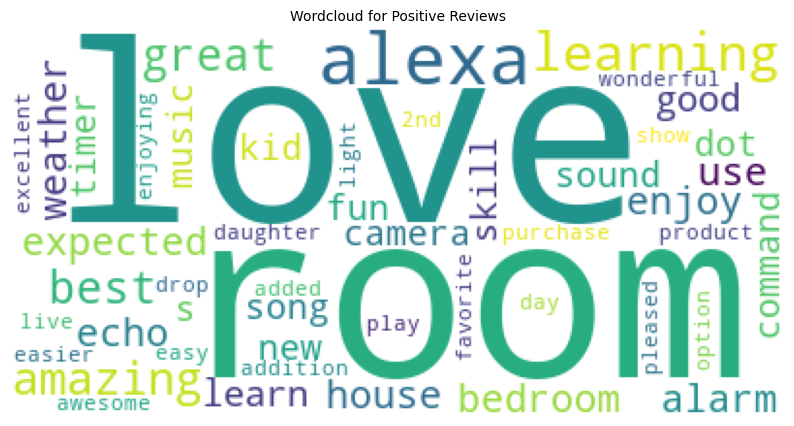

In [73]:
# Create word cloud for positive reviews

wc = WordCloud(background_color='white', max_words=50)

# Generate and plot word cloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_pos_words))
plt.title('Wordcloud for Positive Reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [74]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag of words

In [75]:
cv = CountVectorizer(max_features = 2500)

# Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [77]:
# Saving the Count Vectorizer

pickle.dump(cv, open('models/countVectorizer.pkl', 'wb'))

In [78]:
# Checking the shape of X and y

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [81]:
# Splitting data into train and test set with 30% data with testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

print(f'X train: {X_train.shape}')
print(f'y train: {y_train.shape}')
print(f'X test: {X_test.shape}')
print(f'y test: {y_test.shape}')

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [82]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


We'll scale X_train and X_test so that all values are between 0 and 1.

In [83]:
# Feature scaling

scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [84]:
# Saving the scaler model

pickle.dump(scaler, open('models/scaler.pkl', 'wb'))

#### Random Forest

In [85]:
# Fitting scaled X_train and y_train on Random Forest Classifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [86]:
# Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.944973544973545


In [87]:
# Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

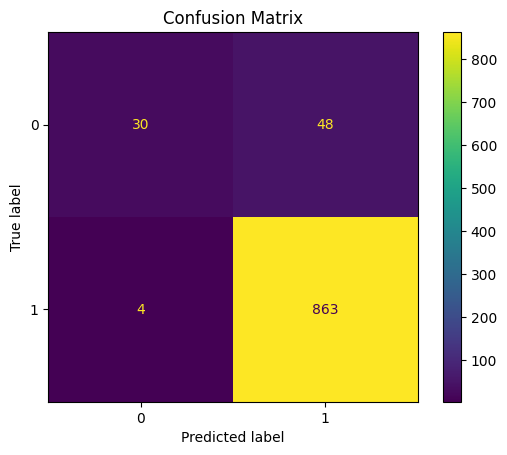

In [93]:
# Confusion matrix

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

K fold cross-validation

In [94]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9337638831756478
Standard Variance : 0.007857162387870814


Applying grid search to get the optimal parameters on random forest

In [95]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [96]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [97]:
# Getting the best parameters from the grid search

print(f"Best parameters : {grid_search.best_params_}")

Best parameters : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [98]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.82395644283122
Cross validation mean accuracy on test set : 92.12794918330309
Accuracy score for test set : 0.944973544973545


#### XGBoost

In [99]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Accuracy of the model on training and testing dat
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [101]:
y_preds = model_xgb.predict(X_test)

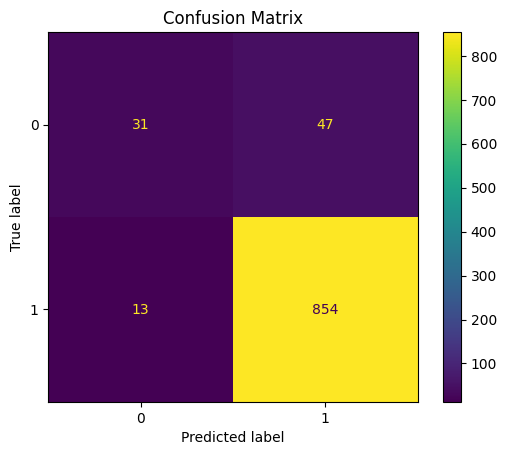

In [102]:
# Confusion matrix

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [104]:
# Saving the XGBoost model

pickle.dump(model_xgb, open('models/xgboost.pkl', 'wb'))

#### Decision Tree Classifier

In [105]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [106]:
# Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9227513227513228


In [107]:
y_preds = model_dt.predict(X_test)

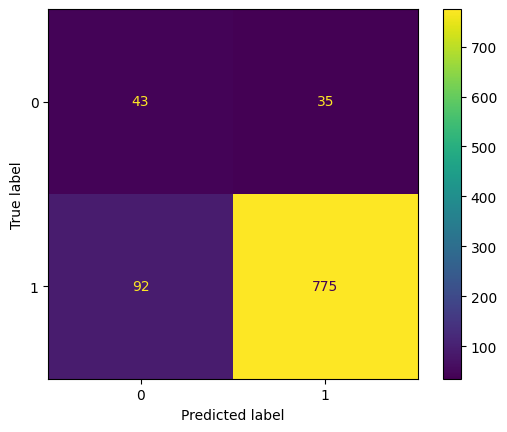

In [108]:
# Confusion matrix

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
disp.plot()

In [109]:
# Saving the Decision Tree model

pickle.dump(model_dt, open('models/decisionTree.pkl', 'wb'))